In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
#from scipy.stats import ttest_ind
#from scipy.stats import linregress
#from sklearn.cluster import KMeans

# Functions

In [ ]:
def scatter_plot(df, x_col, y_col,
                 xlabel = None,
                 ylabel = None, 
                 x_lim=None, 
                 y_lim=None):

    plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(df[x_col], df[y_col], alpha=0.6)

    # --- Spearman correlation ---
    rho, p = spearmanr(df[x_col], df[y_col])

    label = f"Spearman ρ = {rho:.3f}\np = {p:.3f}"

    plt.text(
        0.05, 0.95, label,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    # Set x and y labels
    if xlabel:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(x_col.replace("_", " "))
    
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(y_col.replace("_", " "))

    # Fixed scale
    if x_lim is not None:
        plt.xlim(x_lim)

    if y_lim is not None:
        plt.ylim(y_lim)

    plt.tight_layout()
    plt.show()

def sprearman_correlation(df):
    cols = df.select_dtypes(include="number").columns
    pairs = []

    for i, c1 in enumerate(cols):
        for c2 in cols[i+1:]:
            x, y = df[c1], df[c2]
            mask = x.notna() & y.notna()
            n = int(mask.sum())
            if n > 2:
                r, p = spearmanr(x[mask], y[mask])
                pairs.append({"var1": c1, "var2": c2, "n": n, "spearman_r": r, "p_value": p})

    pairs_df = pd.DataFrame(pairs)
    return pairs_df

def beautiful_boxplot(df_list, labels, ylabel=None, log_scale=False):
    """
    df_list : list of pandas Series (or columns)
    labels  : list of group names
    """

    fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=200)

    # Clean data
    data = [d.dropna() for d in df_list]

    # Boxplot
    box = ax.boxplot(
        data,
        widths=0.5,
        patch_artist=True,
        showfliers=False
    )

    # Soft box colors
    for patch in box['boxes']:
        patch.set(facecolor='lightgray', alpha=0.6)

    # Overlay jittered dots
    for i, y in enumerate(data, start=1):
        x = np.random.normal(i, 0.05, size=len(y))
        ax.scatter(x, y, alpha=0.6, s=20)

    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='out', length=4, width=1)

    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels)

    if ylabel:
        ax.set_ylabel(ylabel)

    if log_scale:
        ax.set_yscale("log")

    plt.tight_layout()
    plt.show()
def _plot_foci_on_image(
    gray_image,
    df,
    x_col="x_px",
    y_col="y_px",
    r_col="sigma_px",
    circle_color="red",
    center_size=6,
    linewidth=1,
    figsize=(7, 7),
    show=True
):
   
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(gray_image, cmap="gray")

    for x_px, y_px, r_px in zip(df[x_col], df[y_col], df[r_col]):
        # circle outline
        ax.add_patch(
            Circle(
                (x_px, y_px),
                r_px,
                fill=False,
                edgecolor=circle_color,
                linewidth=linewidth
            )
        )
        # center dot
        ax.scatter(x_px, y_px, c=circle_color, s=center_size)

    ax.axis("off")

    if show:
        plt.show()

    return fig, ax



# Data import

In [2]:
path = "/mnt/c/users/Elena/Desktop/Data_processing/020226/WT_run/results.csv"
df = pd.read_csv(path)

In [4]:
df.head()

,File_name,Nucleus_area,Nucleus_MFI,Foci_number,All_foci_IFI_photons,All_foci_MFI_px,All_foci_sigma_nm,Outliers_number,Outliers_MFI_px,Outliers_sigma_nm
0,C2_MP_U2OS_fixed_20nMJF549_ORC1_WT.nd2_(series...,302.964,8.484,571,3340.356535,0.052714,104.193224,8,0.170861,107.851326
1,C2_MP_U2OS_fixed_20nMJF549_ORC1_WT.nd2_(series...,298.486,4.601,370,1898.418573,0.034382,96.941138,12,0.124668,112.048329
2,C2_MP_U2OS_fixed_20nMJF549_ORC1_WT.nd2_(series...,354.843,5.894,529,2237.390046,0.042774,99.424278,11,0.135971,137.159365
3,C2_MP_U2OS_fixed_20nMJF549_ORC1_WT.nd2_(series...,352.762,11.008,736,3610.210258,0.064096,102.364615,27,0.222485,123.573123
4,C2_MP_U2OS_fixed_20nMJF549_ORC1_WT.nd2_(series...,579.206,6.531,858,2410.481392,0.047565,99.098344,17,0.178316,120.543213


# Correlation matrix and scatter plots

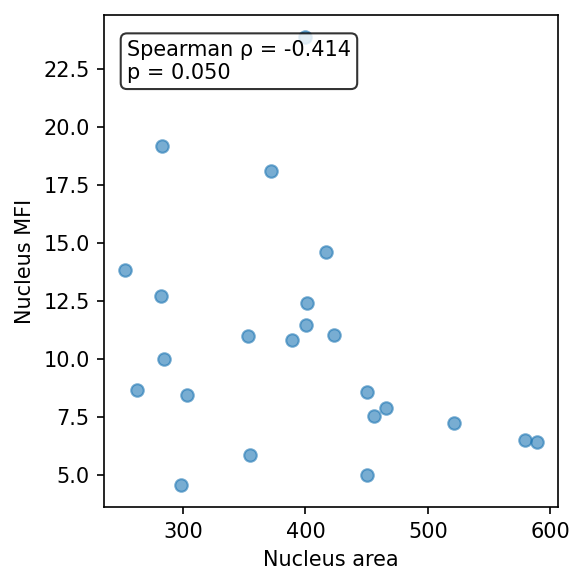

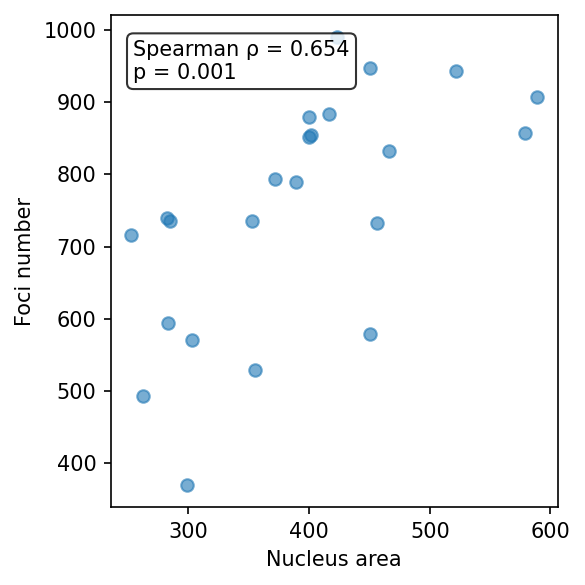

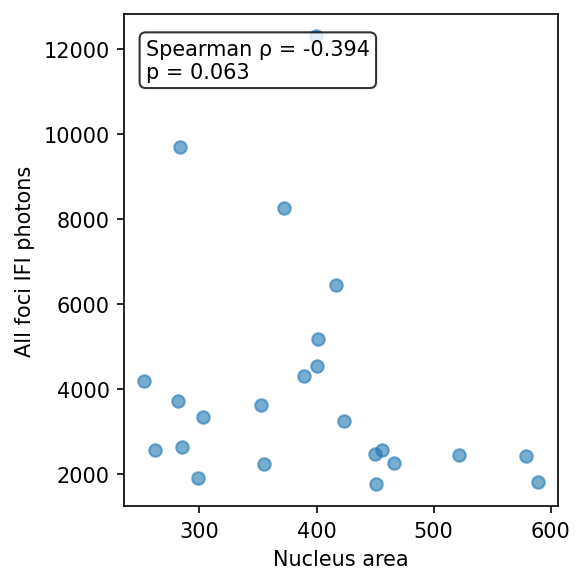

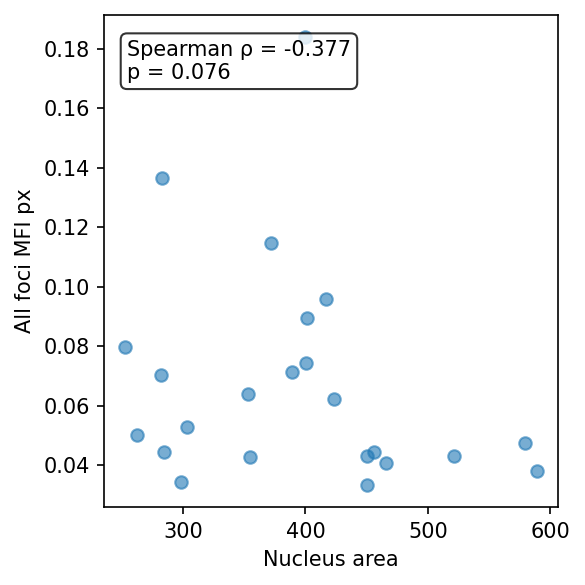

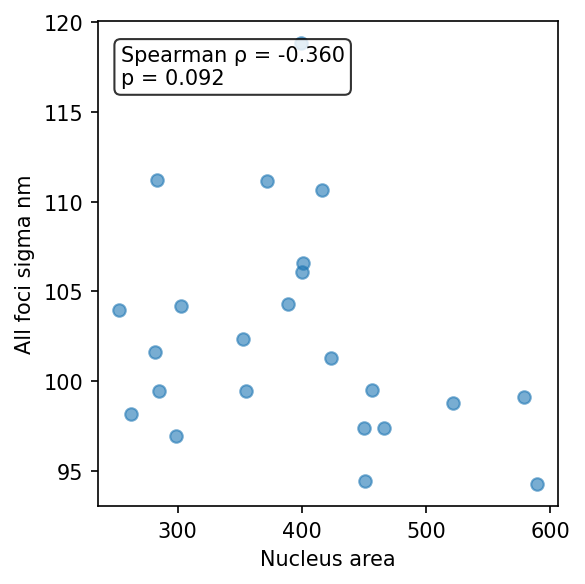

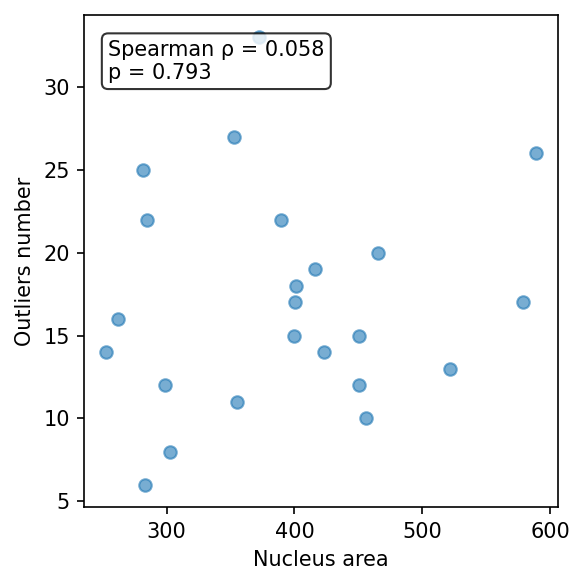

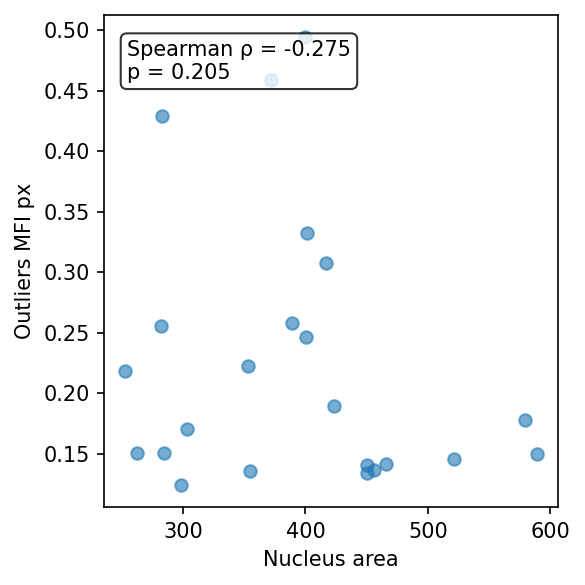

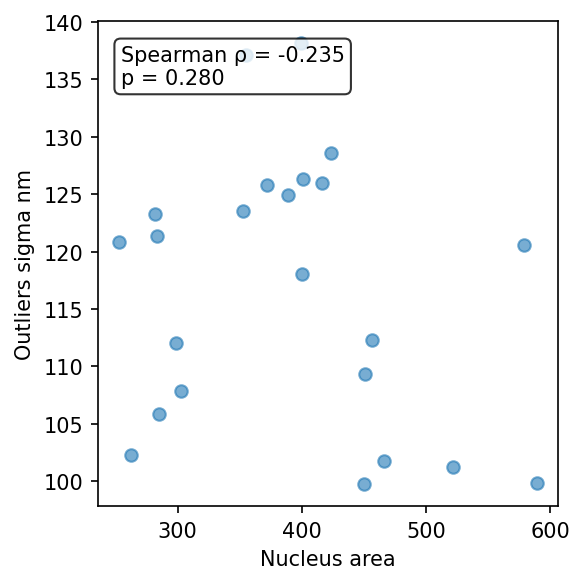

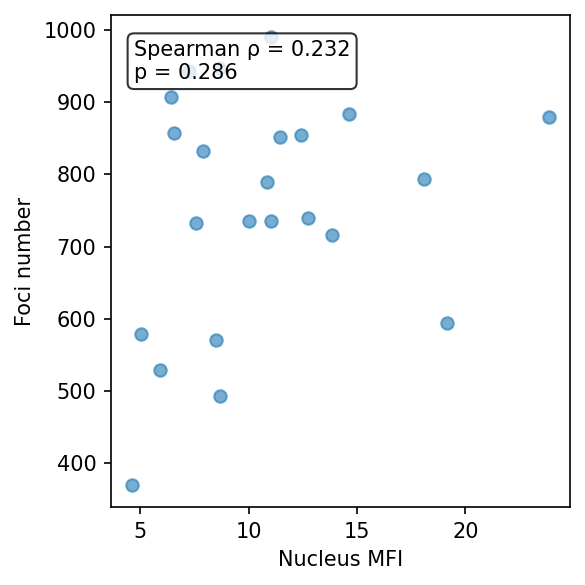

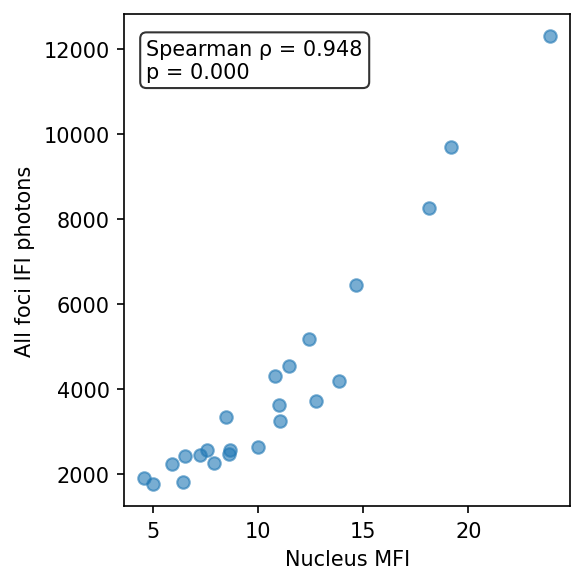

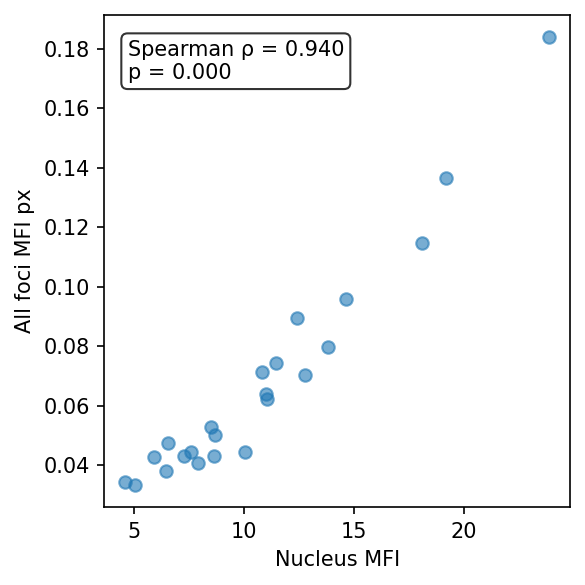

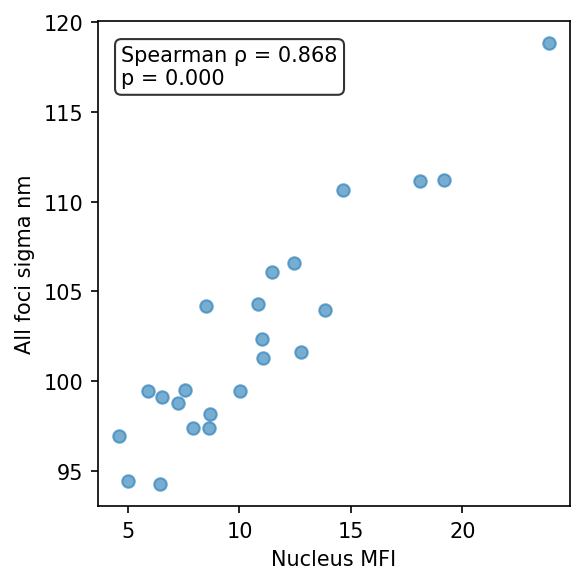

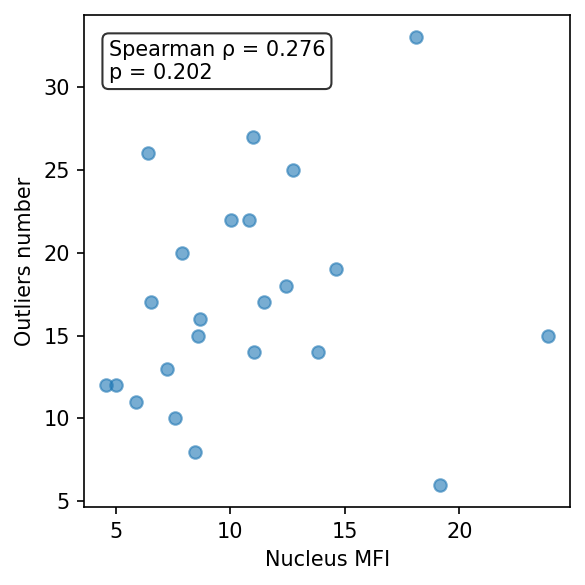

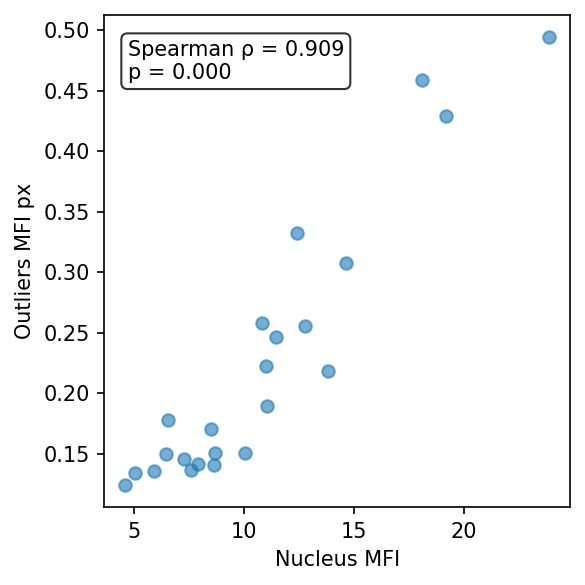

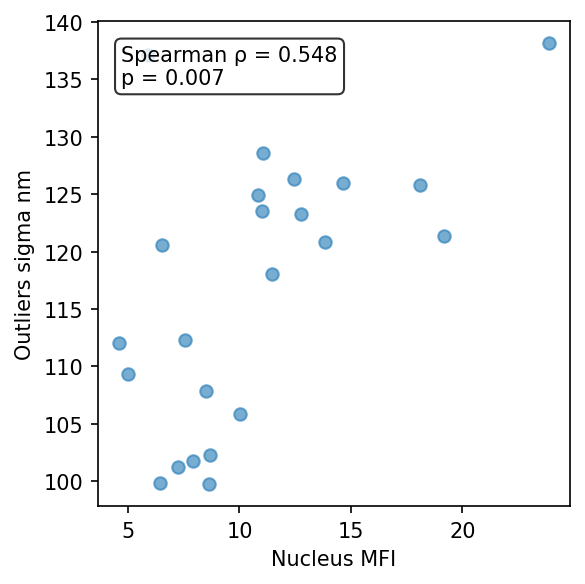

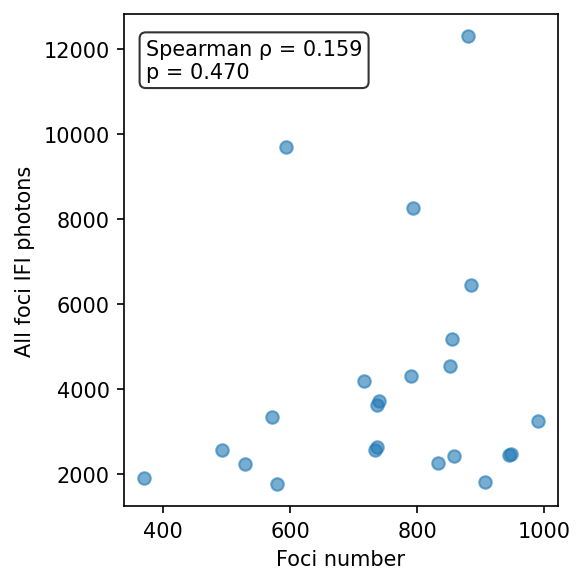

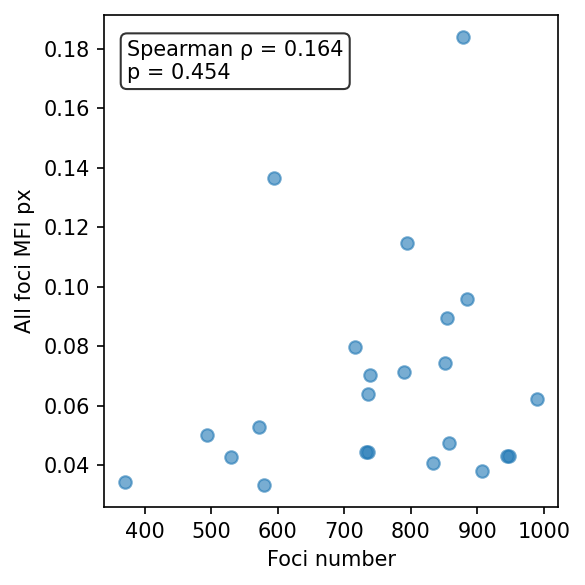

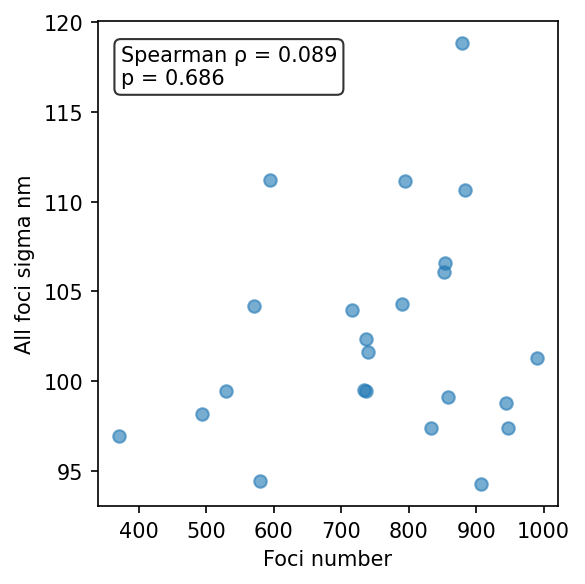

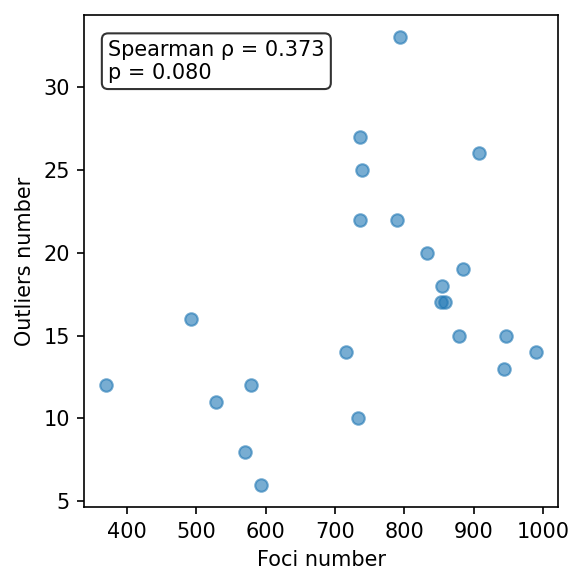

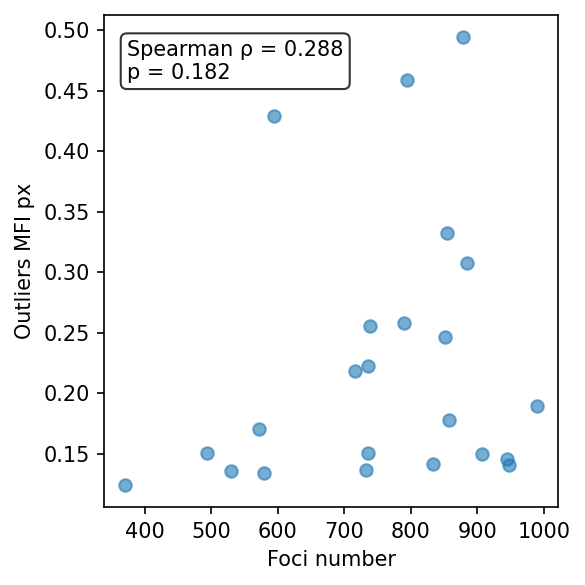

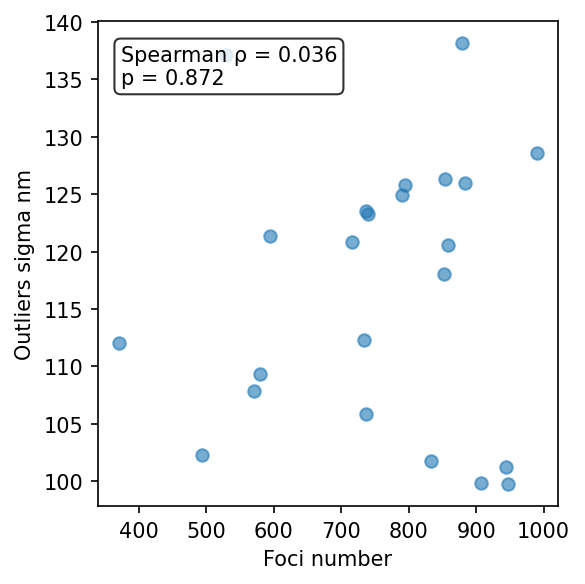

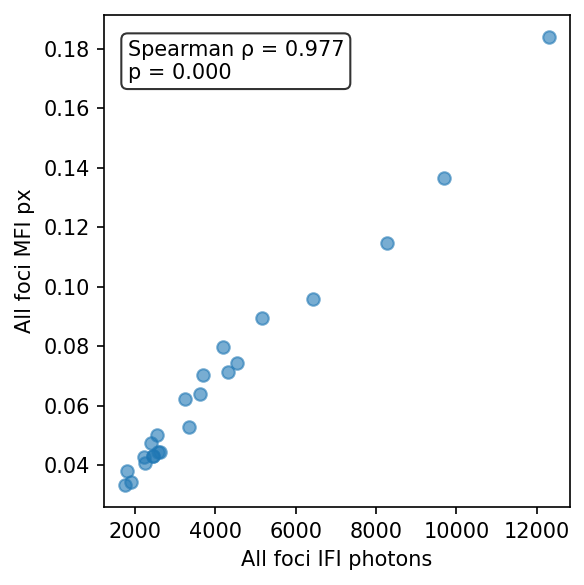

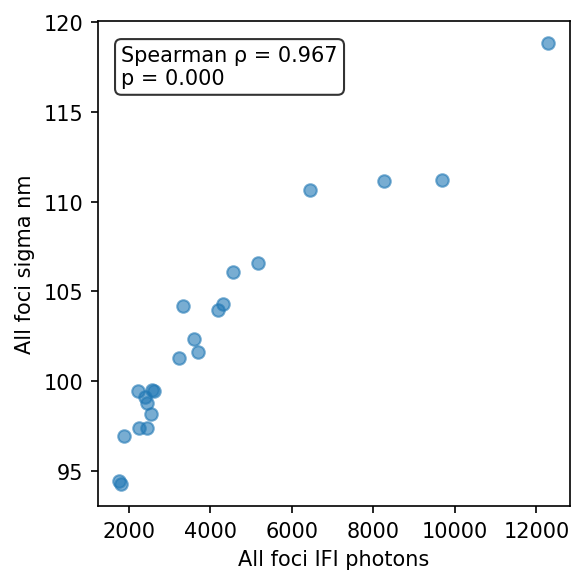

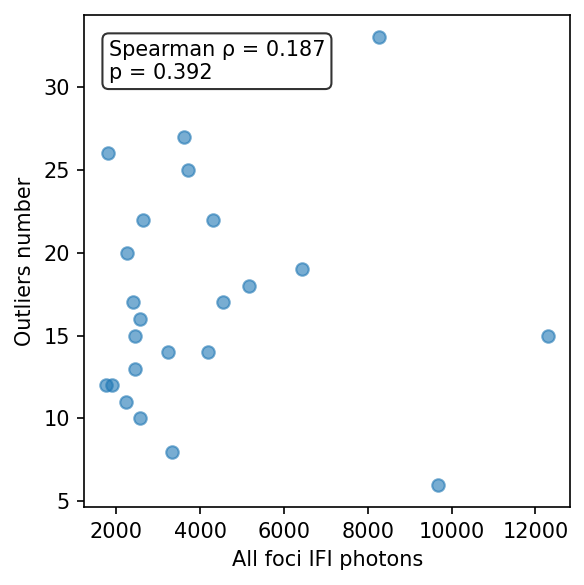

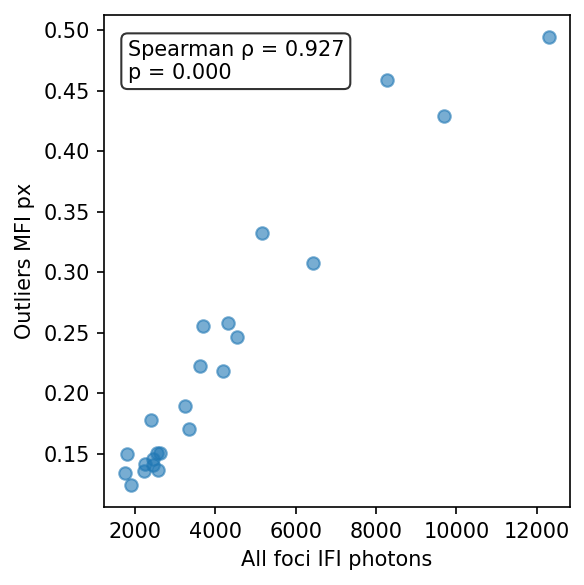

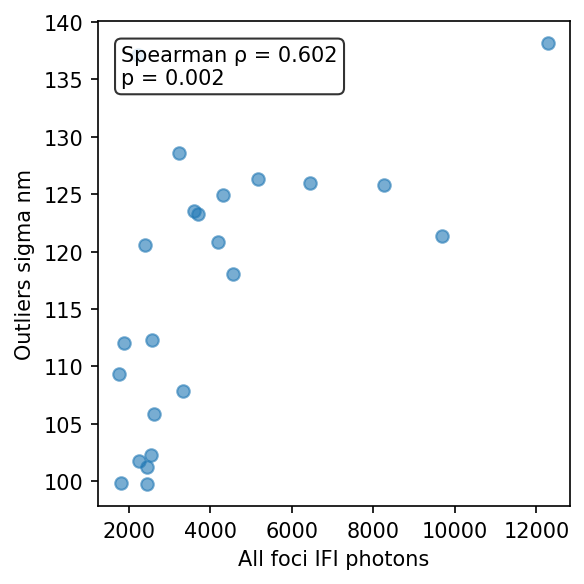

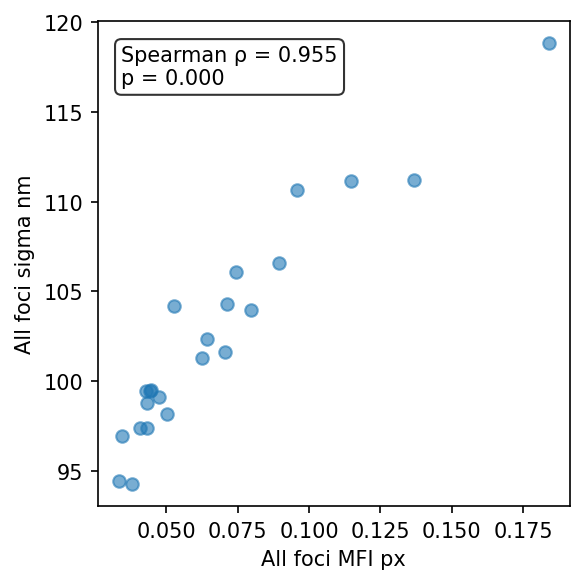

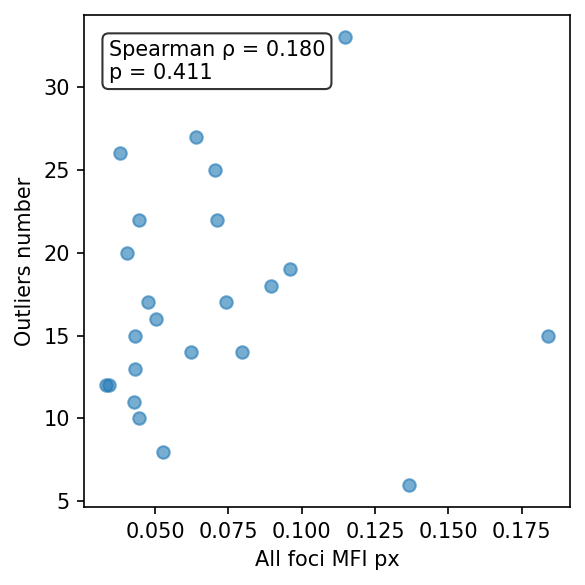

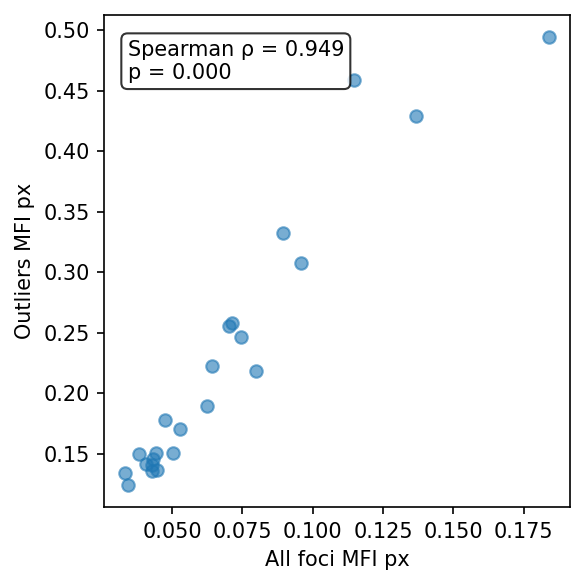

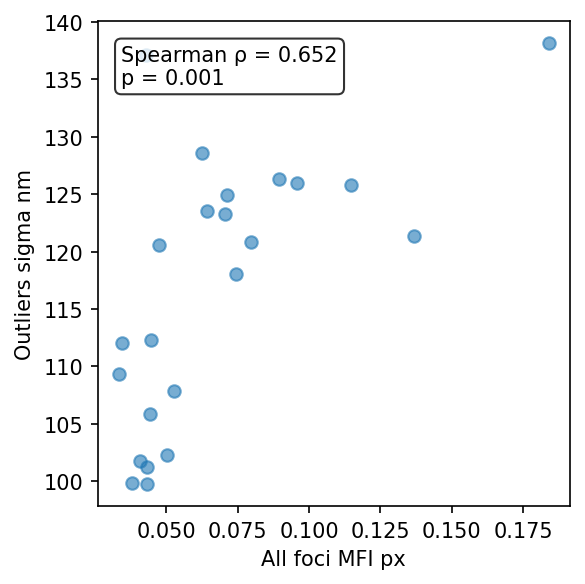

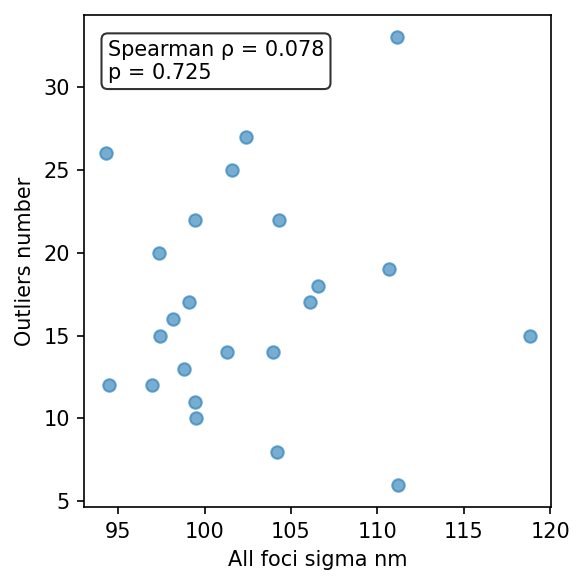

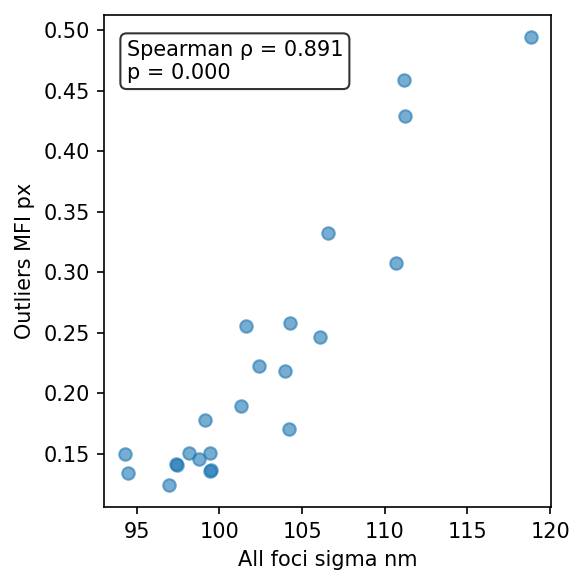

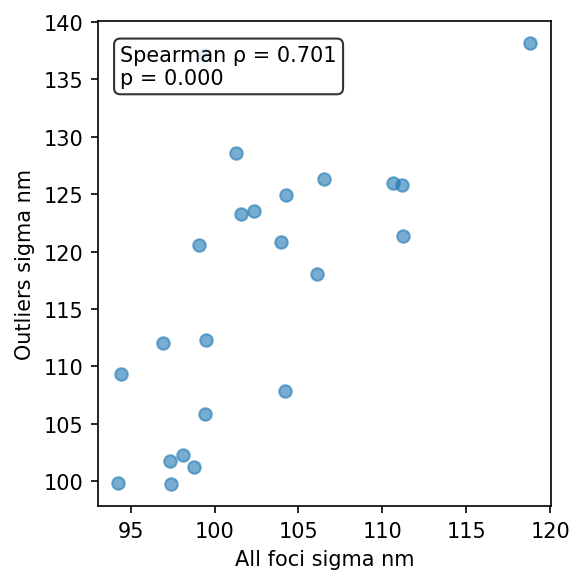

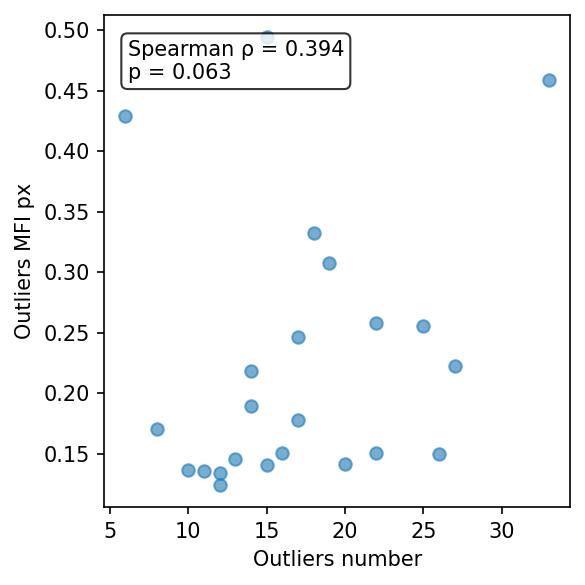

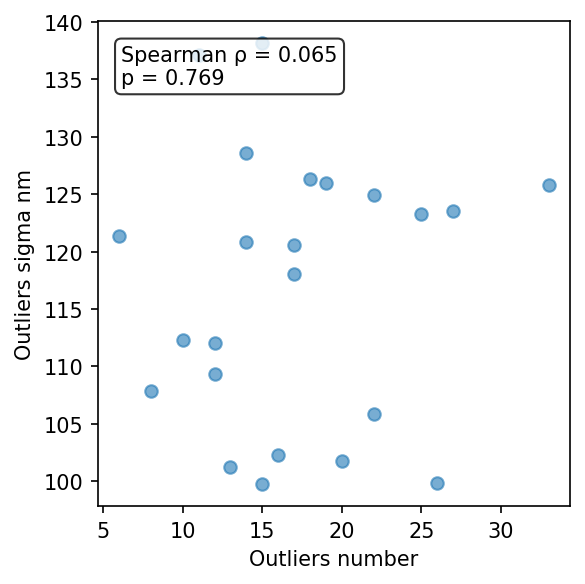

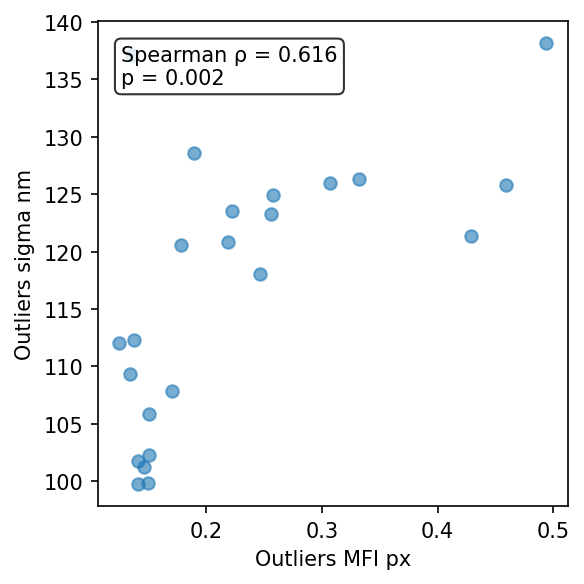

In [45]:
corr = sprearman_correlation(df)
#corr = corr[corr['p_value'] < 0.05]

for v1, v2 in zip(corr['var1'], corr['var2']):
    scatter_plot(df, x_col = v1, y_col = v2)

# Boxplots

In [46]:
df.columns

Index(['File_name', 'Nucleus_area', 'Nucleus_MFI', 'Foci_number',
       'All_foci_IFI_photons', 'All_foci_MFI_px', 'All_foci_sigma_nm',
       'Outliers_number', 'Outliers_MFI_px', 'Outliers_sigma_nm'],
      dtype='str')

## Draw circle area

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(gray, cmap="gray")

for x_px, y_px, r_px in zip(res["x_px"], res["y_px"], res["sigma_px"]):
    # circle outline
    ax.add_patch(Circle((x_px, y_px), r_px, fill=False, edgecolor="red", linewidth=1))
    # center dot
    ax.scatter(x_px, y_px, c="red", s=6)

ax.axis("off")
plt.show()

# Kmean

In [ ]:
n_clusters = 3

# Select TWO columns
X = df[["mean_intensity", "sigma [nm]"]].dropna()

# Run KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Add cluster labels back to dataframe
df.loc[X.index, "cluster"] = labels

centers = kmeans.cluster_centers_

print("Cluster centers:")
for i, c in enumerate(centers):
    print(f"Cluster {i}: mean_intensity={c[0]:.2f}, sigma={c[1]:.2f}")

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(5, 4), dpi=200)

# Scatter plot of clusters
for cluster_id in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster_id]
    plt.scatter(cluster_data["sigma [nm]"],
                cluster_data["mean_intensity"],
                alpha=0.6,
                label=f"Cluster {cluster_id}")

# Plot cluster centers
plt.scatter(centers[:, 1],   # sigma
            centers[:, 0],   # mean_intensity
            marker="X",
            s=200,
            linewidths=2,
            edgecolors="black",
            label="Centers")

plt.xlabel("Sigma")
plt.ylabel("Mean intensity")
plt.title("KMeans Clustering (Sigma vs Intensity)")
plt.legend()

# Clean look
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


# Filtration

In [ ]:
df_bright = df[df["sigma [nm]"] > 400]
df_medium = df[(df["sigma [nm]"] > 150) & (df["sigma [nm]"] <= 400)]
df_dark = df[df["sigma [nm]"] <= 150]

print("Bright foci count:", df_bright.shape[0])
print("Medium foci count:", df_medium.shape[0])
print("Dark foci count:", df_dark.shape[0])

In [ ]:
df1 = df[df["sigma [nm]"] > 500]
print("Bright foci count:", df1.shape[0])